In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import torch
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler, DataCollatorWithPadding, TrainingArguments, Trainer
from torch.optim import AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model
from tqdm.auto import tqdm
import evaluate

## Load Dataset

In [4]:
from datasets import load_dataset

squad = load_dataset("squad_v2")

In [5]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [6]:
num_training_samples = 15000
num_test_samples = 750
num_validation_samples = 1000
training_samples = squad['train'].select([i for i in range(num_training_samples)])
test_samples = squad['train'].select([i for i in range(num_training_samples, num_training_samples+num_test_samples)])
validation_samples = squad['validation'].select([i for i in range(num_validation_samples)])
print(training_samples)
print(test_samples)
print(validation_samples)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 15000
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 750
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})


In [7]:
training_samples[0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [ ]:
from transformers import AutoTokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [9]:
# Explicitly set the chat template clearly:
tokenizer.chat_template = (
    "{% for message in messages %}"
    "{% if message['role'] == 'system' %}<|system|>\n{{ message['content'] }}\n"
    "{% elif message['role'] == 'user' %}<|start_header_id|>user<|end_header_id|>{{ message['content'] }}<|eot_id|>"
    "{% elif message['role'] == 'assistant' %}<|start_header_id|>assistant<|end_header_id|>{{ message['content'] }}<|eot_id|>"
    "{% endif %}"
    "{% endfor %}"
)

In [10]:
def convert_squad_sample_to_llama_conversation(sample):
    # get the question and context for this sample
    question = sample['question']
    context = sample['context']

    # some questions can have multiple answers, some none at all,
    # for the case of no answers we'll have the model output that the
    # context does not provide an answer, if it has multiple we'll just take
    # the first answer as the ground truth.
    answers = sample['answers']['text']
    if len(answers) == 0 :
      answer = "The context does not provide an answer..."
    else:
      answer = sample['answers']['text'][0]

    # now we define an initial model prompt defining the task and giving the model the context passage
    instruction_prompt_template = '''
    You are a helpful assistant tasked with extracting passages that answer users questions from a given context. Output exact passages word for word that answer the users question. Do not output any other text other than passages in the context passage. Output the minimal amount to answer the question, for example only 2-3 words from the passage. If you cannot find the answer in the context passage output 'The context does not provide an answer...'

    Context: {context}'''

    # now we'll convert these into a list of messages for our conversation
    messages = [
        {"role": "system", "content": instruction_prompt_template.format(context=context)},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]
    # apply the chat template and return the sample
    # we'll also return the single answer we expect and the list of messages without
    # the chat template in case we need them later.
    sample_conversation = tokenizer.apply_chat_template(messages, tokenize=False)
    return {"text": sample_conversation, "messages": messages, "answer": answer}

In [11]:
conversation_training_samples = training_samples.map(convert_squad_sample_to_llama_conversation)
conversation_test_samples = test_samples.map(convert_squad_sample_to_llama_conversation)
conversation_validation_samples = validation_samples.map(convert_squad_sample_to_llama_conversation)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Model Preparation

In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "_name_or_path": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "vocab_size": 32000
}

CUDA backend validation successful.
Overriding t

ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [13]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

In [14]:
from peft import LoraConfig
# rank defines the rank of the adapter matrix,
# the higher the rank, the more complex the task it's trying to learn
rank = 128

# the alpha is a scaling factor hyper parameter, basically controls how much our
# adapter will influence the models output, the higher this value
# the more our adapter will overpower the original model weights.
# there is a lot of advice out there for what the alpha value should be
# keeping the alpha at around 2x of what the rank is works for this notebook
alpha = rank*2
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    lora_dropout=0.05, # dropout for the lora layers while training, to avoid overfitting
    bias="none",
    task_type="CAUSAL_LM",
    # the target modules defines what types of layers to add lora adapters too, so in the network
    # any model that have a name in this list will have a lora adapter added to it,
    target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj']
)

## Model Training

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

model_checkpoint_path = "./model/llama3.2-1b"

# an important note is that the loss function isn't defined here,
# it's instead stored as a model parameter for models in hf,
# in the case of llama it is cross entropy loss

# first define some training arguments
training_arguments = TrainingArguments(
    output_dir=model_checkpoint_path,
    optim='adafactor', #specify what optimizer we wwant to use, in this case a 8bit version of adamw with pagination.
    per_device_train_batch_size=8, # define the number of samples per training batch
    gradient_accumulation_steps=4, # define how many steps to accumulate gradients,
    log_level='debug',
    eval_strategy = "steps",
    save_strategy='steps', # we'll save a checkpoint every epoch
    logging_steps=8,
    eval_steps=8,
    save_steps=8,
    learning_rate=1e-5, # for llm training we want a fairly high learning rate, 1e-4 is a good starting point but it's worth it to play around with this value
    fp16=True,
    num_train_epochs=4,
    max_steps=120,
    warmup_ratio=0.1,
    load_best_model_at_end = True,
    overwrite_output_dir = True,
    lr_scheduler_type='linear',# and set our learning rate decay
)

# now that we have our arguments, we'll use that to create our trainer,
# passing in the model, dataset, peft config, tokenizer, ect
trainer = SFTTrainer(
    model=model,
    train_dataset=conversation_training_samples,
    eval_dataset=conversation_test_samples,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments
)

ValueError: adamw is not a valid OptimizerNames, please select one of ['adamw_hf', 'adamw_torch', 'adamw_torch_fused', 'adamw_torch_xla', 'adamw_torch_npu_fused', 'adamw_apex_fused', 'adafactor', 'adamw_anyprecision', 'adamw_torch_4bit', 'adamw_torch_8bit', 'ademamix', 'sgd', 'adagrad', 'adamw_bnb_8bit', 'adamw_8bit', 'ademamix_8bit', 'lion_8bit', 'lion_32bit', 'paged_adamw_32bit', 'paged_adamw_8bit', 'paged_ademamix_32bit', 'paged_ademamix_8bit', 'paged_lion_32bit', 'paged_lion_8bit', 'rmsprop', 'rmsprop_bnb', 'rmsprop_bnb_8bit', 'rmsprop_bnb_32bit', 'galore_adamw', 'galore_adamw_8bit', 'galore_adafactor', 'galore_adamw_layerwise', 'galore_adamw_8bit_layerwise', 'galore_adafactor_layerwise', 'lomo', 'adalomo', 'grokadamw', 'schedule_free_radam', 'schedule_free_adamw', 'schedule_free_sgd', 'apollo_adamw', 'apollo_adamw_layerwise']

In [16]:
trainer.model.print_trainable_parameters()

trainable params: 100,925,440 || all params: 1,200,973,824 || trainable%: 8.4036


In [17]:
initial_eval_values = trainer.evaluate()
print(initial_eval_values)
initial_eval_loss = initial_eval_values['eval_loss']

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: question, answers, context, title, id, answer, text. If question, answers, context, title, id, answer, text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'eval_loss': 2.672109365463257, 'eval_model_preparation_time': 0.002, 'eval_runtime': 15.6049, 'eval_samples_per_second': 48.062, 'eval_steps_per_second': 6.024}


In [18]:
trainer.train()

Currently training with a batch size of: 8
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: question, answers, context, title, id, answer, text. If question, answers, context, title, id, answer, text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15,000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 120
  Number of trainable parameters = 100,925,440
/home/hans/miniconda3/envs/moba/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve t

Step,Training Loss,Validation Loss,Model Preparation Time
8,2.179600,1.363259,0.002000
16,1.239600,1.010158,0.002000
24,1.090100,0.984117,0.002000
32,1.117500,0.975623,0.002000
40,1.041200,0.972470,0.002000
48,1.058400,0.972669,0.002000
56,1.041100,0.970100,0.002000
64,1.022300,0.971979,0.002000
72,0.995300,0.970095,0.002000
80,0.971000,0.971331,0.002000


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: question, answers, context, title, id, answer, text. If question, answers, context, title, id, answer, text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 750
  Batch size = 8
Saving model checkpoint to ./model/tiny-llama/checkpoint-8
loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias"

TrainOutput(global_step=120, training_loss=1.1158244331677756, metrics={'train_runtime': 807.982, 'train_samples_per_second': 4.753, 'train_steps_per_second': 0.149, 'total_flos': 1.264995821469696e+16, 'train_loss': 1.1158244331677756})

In [19]:
# initial_eval_values = trainer.evaluate()
# print(initial_eval_values)
# initial_eval_loss = initial_eval_values['eval_loss']

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: context, text, id, question, title, answer, answers. If context, text, id, question, title, answer, answers are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'eval_loss': 1.13447105884552, 'eval_model_preparation_time': 0.0031, 'eval_runtime': 3123.112, 'eval_samples_per_second': 0.24, 'eval_steps_per_second': 0.03}


[2.1796, 1.2396, 1.0901, 1.1175, 1.0412, 1.0584, 1.0411, 1.0223, 0.9953, 0.971, 1.038, 0.9827, 1.002, 0.9673, 0.9914]
[2.672109365463257, 1.3632590770721436, 1.0101580619812012, 0.9841168522834778, 0.975623369216919, 0.9724697470664978, 0.9726694226264954, 0.9700997471809387, 0.9719794988632202, 0.970095157623291, 0.9713305830955505, 0.9726958870887756, 0.9715316295623779, 0.9710776209831238, 0.9711250066757202, 0.9709919691085815]


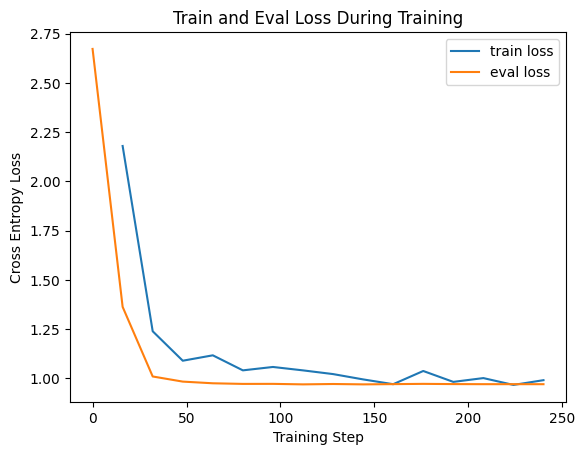

In [19]:
training_loss_history = []
eval_loss_history = [initial_eval_loss]
for step in trainer.state.log_history:
  if 'loss' in step:
    training_loss_history.append(step['loss'])
  elif "eval_loss" in step:
    eval_loss_history.append(step['eval_loss'])

print(training_loss_history)
print(eval_loss_history)

import matplotlib.pyplot as plt
time_steps = [i*16 for i in range(1, len(training_loss_history)+1)]
plt.plot(time_steps, training_loss_history, label="train loss")
plt.plot([0]+time_steps, eval_loss_history, label="eval loss")
plt.title("Train and Eval Loss During Training")
plt.xlabel("Training Step")
plt.ylabel("Cross Entropy Loss")
plt.legend(loc="upper right")
plt.show()

## Inference

In [ ]:
modelpath = "./results/llama3.2-1b"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(modelpath)

In [ ]:
from peft import PeftModel, PeftConfig

base_model_name = "meta-llama/Llama-3.2-1B"
trained_adapter_dir = modelpath  # your checkpoint folder clearly stated here

# Load base tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Clearly load base model explicitly
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Explicitly load your trained LoRA adapters clearly
model = PeftModel.from_pretrained(base_model, trained_adapter_dir)

# Set tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model.eval()

# Use model explicitly for inference clearly
prompt = "When did Beyonce start becoming popular?"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    output = model.generate(**inputs, max_length=256)

response = tokenizer.decode(output.squeeze(), skip_special_tokens=True)
print(response)